In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool
import yaml

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn import preprocessing
from sklearn.metrics import calinski_harabaz_score as score_ch
from sklearn.metrics import silhouette_score as score_sil

%matplotlib inline

## Load Data

In [2]:
order_products = pd.read_csv("../../data/external/order_products__train.csv")
order_products_prior = pd.read_csv("../../data/external/order_products__prior.csv")
orders = pd.read_csv("../../data/external/orders.csv")
products = pd.read_csv("../../data/external/products.csv")
aisles = pd.read_csv("../../data/external/aisles.csv")
departments = pd.read_csv("../../data/external/departments.csv")

In [3]:
products.set_index('product_id', inplace=True)
orders.set_index('order_id', inplace=True)
aisles.set_index('aisle_id', inplace=True)
departments.set_index('department_id', inplace=True)

In [5]:
order_products = pd.concat([order_products, order_products_prior])
del order_products_prior

## Inspect Data

In [14]:
table = '''\
Unique Products: {}
Order_Products:  {}
Orders:          {}
Aisles:          {}
Departments:     {}
Users:           {}'''
print(table.format(len(products), len(order_products), len(orders),
      len(aisles), len(departments), orders.user_id.nunique()))

Unique Products: 49688
Order_Products:  33819106
Orders:          3421083
Aisles:          134
Departments:     21
Users:           206209


In [ ]:
products.dtypes

In [ ]:
products.head()

In [ ]:
orders.head()

In [ ]:
order_products.head()

In [ ]:
aisles.head()

In [ ]:
departments.head()

In [ ]:
products.nunique()

In [ ]:
products.groupby('department_id').nunique()[['product_name', 'aisle_id']]

In [ ]:
order_products.dtypes

## Product Features

In [5]:
n_orders = order_products.groupby('product_id').size()
n_orders.name = 'n_orders'
products = products.join(n_orders)

In [6]:
top_n = 5

In [7]:
top_products = products.groupby('department_id')['n_orders'].nlargest(top_n).reset_index()

In [8]:
top_products['rank'] = list(range(1,top_n+1)) * (len(top_products) // top_n)

In [9]:
top_products = top_products.join(products[['product_name']], on='product_id')
top_products = top_products.join(departments[['department']], on='department_id')

In [10]:
top_products.head(10)

,department_id,product_id,n_orders,rank,product_name,department
0,1,9076,58269.0,1,Blueberries,frozen
1,1,20995,34248.0,2,Organic Broccoli Florets,frozen
2,1,24489,32658.0,3,Organic Whole Strawberries,frozen
3,1,17948,30970.0,4,Frozen Organic Wild Blueberries,frozen
4,1,46802,26027.0,5,Pineapple Chunks,frozen
5,2,38662,4150.0,1,Roasted Almond Butter,other
6,2,26756,1622.0,2,Light CocoWhip! Coconut Whipped Topping,other
7,2,32115,1358.0,3,93/7 Ground Beef,other
8,2,13475,852.0,4,Coconut Almond Granola,other
9,2,39461,816.0,5,Coffee Mate French Vanilla Creamer Packets,other


In [11]:
top_products.pivot(index='department', columns='rank', values='product_name')

rank,1,2,3,4,5
department,,,,,
alcohol,Sauvignon Blanc,Cabernet Sauvignon,Chardonnay,Beer,Vodka
babies,Baby Food Stage 2 Blueberry Pear & Purple Carrot,Spinach Peas & Pear Stage 2 Baby Food,Gluten Free SpongeBob Spinach Littles,Broccoli & Apple Stage 2 Baby Food,Free & Clear Unscented Baby Wipes
bakery,100% Whole Wheat Bread,Organic Bread with 21 Whole Grains,Ezekiel 4:9 Bread Organic Sprouted Whole Grain,Sourdough Bread,Original Nooks & Crannies English Muffins
beverages,Sparkling Water Grapefruit,Spring Water,Lime Sparkling Water,Sparkling Natural Mineral Water,100% Raw Coconut Water
breakfast,Honey Nut Cheerios,Organic Old Fashioned Rolled Oats,Raisin Bran Cereal,Cereal,Organic Quick Oats
bulk,Dried Mango,Organic Rolled Oats,Organic Black Mission Figs,Apricots,Rolled Oats
canned goods,Organic Black Beans,Organic Garbanzo Beans,No Salt Added Black Beans,Organic Diced Tomatoes,Organic Tomato Paste
dairy eggs,Organic Whole Milk,Organic Half & Half,Half & Half,Organic Whole String Cheese,Organic Unsweetened Almond Milk
deli,Original Hummus,Uncured Genoa Salami,Organic Extra Firm Tofu,Organic Roasted Turkey Breast,Oven Roasted Turkey Breast


In [12]:
order_products.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [13]:
print('Percent of products organic:')
len(products[products['product_name'].str.lower().str.contains('organic')]) / len(products)

Percent of products organic:


0.1013524392207374

In [14]:
print(list(departments.department))

['frozen', 'other', 'bakery', 'produce', 'alcohol', 'international', 'beverages', 'pets', 'dry goods pasta', 'bulk', 'personal care', 'meat seafood', 'pantry', 'breakfast', 'canned goods', 'dairy eggs', 'household', 'babies', 'snacks', 'deli', 'missing']


Classify products as grocery or other

In [15]:
groceries = ['frozen', 'bakery', 'produce', 'alcohol', 'international',
             'beverages', 'dry goods pasta', 'bulk', 'meat seafood', 'pantry',
             'breakfast', 'canned goods', 'dairy eggs', 'snacks', 'deli']
departments['grocery'] = departments['department'].isin(groceries).astype(int)

In [16]:
departments.head()

,department,grocery
department_id,,
1,frozen,1
2,other,0
3,bakery,1
4,produce,1
5,alcohol,1


Add categorical markers to products

In [17]:
products['organic'] = products['product_name'].str.lower().str.contains('organic').astype(int)

In [18]:
products['popular'] = products['product_name'].isin(top_products.values.reshape(-1)).astype(int)

In [19]:
with open('../../data/external/cats.yml') as f:
    cats = yaml.load(f)

In [20]:
cats['veg']

['prepared soups salads',
 'tofu meat alternatives',
 'bulk dried fruits vegetables',
 'fresh fruits',
 'packaged produce',
 'frozen vegan vegetarian',
 'fruit vegetable snacks',
 'canned jarred vegetables',
 'fresh vegetables',
 'pickled goods olives',
 'frozen produce',
 'nuts seeds dried fruit',
 'packaged vegetables fruits']

In [21]:
for cat in cats:
    aisles[cat] = aisles['aisle'].isin(cats[cat]).astype(int)

In [22]:
aisles.head()

,aisle,prepared,dairy,gluten,snack,meat,fish,beverage,veg
aisle_id,,,,,,,,,
1,prepared soups salads,1,0,0,0,0,0,0,1
2,specialty cheeses,0,1,0,0,0,0,0,0
3,energy granola bars,0,0,1,1,0,0,0,0
4,instant foods,1,0,0,0,0,0,0,0
5,marinades meat preparation,0,0,0,0,1,0,0,0


In [23]:
# Check that aisles are mapped 1-to-1 to departments
(products.pivot_table(index='aisle_id',
                      columns='department_id',
                      values='n_orders').fillna(0) > 0).sum(axis=1).values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

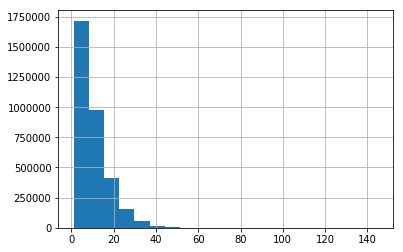

In [24]:
order_products['order_id'].value_counts().rename('counts').hist(bins=20)

In [25]:
orders = orders.join(order_products['order_id'].value_counts().rename('order_size'))
orders['size_cat'] = pd.cut(orders['order_size'], [0,5,10,20,np.inf], labels=['small', 'medium', 'large', 'xl'])
orders.head()

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,order_size,size_cat
order_id,,,,,,,,
2539329,1,prior,1,2,8,NaN,5.0,small
2398795,1,prior,2,3,7,15.0,6.0,medium
473747,1,prior,3,3,12,21.0,5.0,small
2254736,1,prior,4,4,7,29.0,5.0,small
431534,1,prior,5,4,15,28.0,8.0,medium


Combine data for final set

In [26]:
full = order_products.join(orders, on='order_id').join(products, on='product_id').join(aisles, on='aisle_id')
print(full.columns)
full.head(10)

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'user_id',
       'eval_set', 'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'order_size', 'size_cat', 'product_name',
       'aisle_id', 'department_id', 'n_orders', 'organic', 'popular', 'aisle',
       'prepared', 'dairy', 'gluten', 'snack', 'meat', 'fish', 'beverage',
       'veg'],
      dtype='object')


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,...,popular,aisle,prepared,dairy,gluten,snack,meat,fish,beverage,veg
0,1,49302,1,1,112108,train,4,4,10,9.0,...,0,yogurt,0,1,0,0,0,0,0,0
1,1,11109,2,1,112108,train,4,4,10,9.0,...,0,other creams cheeses,0,1,0,0,0,0,0,0
2,1,10246,3,0,112108,train,4,4,10,9.0,...,0,fresh vegetables,0,0,0,0,0,0,0,1
3,1,49683,4,0,112108,train,4,4,10,9.0,...,0,fresh vegetables,0,0,0,0,0,0,0,1
4,1,43633,5,1,112108,train,4,4,10,9.0,...,0,canned meat seafood,1,0,0,0,1,1,0,0
5,1,13176,6,0,112108,train,4,4,10,9.0,...,1,fresh fruits,0,0,0,0,0,0,0,1
6,1,47209,7,0,112108,train,4,4,10,9.0,...,1,fresh fruits,0,0,0,0,0,0,0,1
7,1,22035,8,1,112108,train,4,4,10,9.0,...,1,packaged cheese,1,1,0,0,0,0,0,0
8,36,39612,1,0,79431,train,23,6,18,30.0,...,0,specialty cheeses,0,1,0,0,0,0,0,0
9,36,19660,2,1,79431,train,23,6,18,30.0,...,1,water seltzer sparkling water,0,0,0,0,0,0,1,0


In [27]:
full['aisle'].value_counts().head()

fresh fruits                  3792661
fresh vegetables              3568630
packaged vegetables fruits    1843806
yogurt                        1507583
packaged cheese               1021462
Name: aisle, dtype: int64

## Order features

In [28]:
groups = full.groupby('order_id')

In [29]:
order_types = groups.agg({
    # product descriptors
    'reordered':  'mean',
    'organic':    'mean',
    'popular':    'mean',
    'prepared':   'mean',
    'dairy':      'mean',
    'gluten':     'mean',
    'snack':      'mean',
    'meat':       'mean',
    'fish':       'mean',
    'beverage':   'mean',
    'veg':        'mean'
}).join(orders[['order_dow', 'order_hour_of_day', 'days_since_prior_order',
                'eval_set', 'order_number', 'order_size', 'user_id']])
order_types.head()

,reordered,organic,popular,prepared,dairy,gluten,snack,meat,fish,beverage,veg,order_dow,order_hour_of_day,days_since_prior_order,eval_set,order_number,order_size,user_id
order_id,,,,,,,,,,,,,,,,,,
1,0.500000,0.625000,0.375000,0.250000,0.375000,0.000000,0.000000,0.125000,0.125,0.000000,0.500000,4,10,9.0,train,4,8.0,112108
2,0.666667,0.222222,0.000000,0.111111,0.000000,0.222222,0.111111,0.000000,0.000,0.000000,0.333333,5,9,8.0,prior,3,9.0,202279
3,1.000000,0.500000,0.250000,0.250000,0.125000,0.125000,0.000000,0.125000,0.000,0.000000,0.375000,5,17,12.0,prior,16,8.0,205970
4,0.923077,0.000000,0.000000,0.076923,0.000000,0.230769,0.615385,0.000000,0.000,0.153846,0.000000,1,9,7.0,prior,36,13.0,178520
5,0.807692,0.153846,0.076923,0.269231,0.115385,0.153846,0.192308,0.038462,0.000,0.038462,0.307692,6,16,9.0,prior,42,26.0,156122


In [30]:
X = order_types.drop(columns=['order_dow', 'order_hour_of_day', 'days_since_prior_order',
                              'eval_set', 'order_number', 'user_id']).values
X[0]

array([0.5  , 0.625, 0.375, 0.25 , 0.375, 0.   , 0.   , 0.125, 0.125,
       0.   , 0.5  , 8.   ])

In [31]:
sum(np.isnan(X))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Order Clustering

In [32]:
X_scaled = preprocessing.scale(X)

In [33]:
km_settings = list(range(4, 13))

In [34]:
def km_evaluate(k):
    km = KMeans(n_clusters=k)
    km.fit(X_scaled)
    labels = km.labels_
    return (k, score_sil(X_scaled, labels), score_ch(X_scaled, labels))

In [35]:
with Pool(processes=6) as p:
    km_scores = p.map(km_evaluate, km_settings)

KeyboardInterrupt: 

In [ ]:
km_scores

In [ ]:
best_km = km_scores[np.argmin(list(map(lambda x: x[1], km_scores)))]
score = best_km[1]
print('Best KM found: k={} with sil score of {}'.format(best_km[0], score))
km = KMeans(best_km[0]).fit(X_scaled)
labels = km.labels_
print('Pseudo-F Score: {}'.format(best_km[2]))

In [38]:
gmm_settings = [(n, t) for n in range(4, 13) for t in ['spherical', 'tied', 'diag', 'full']]
gmm_settings[:3]

[(4, 'spherical'), (4, 'tied'), (4, 'diag')]

In [39]:
def gmm_evaluate(setting):
    n_components, cv_type = setting
    gmm = GMM(n_components=n_components,
              covariance_type=cv_type)
    gmm.fit(X_scaled)
    labels = gmm.predict(X_scaled)
    return (n_components, cv_type, gmm.bic(X_scaled), score_ch(X_scaled, labels))

In [40]:
with Pool(processes=6) as p:
    gmm_scores = p.map(gmm_evaluate, gmm_settings)

KeyboardInterrupt: 

In [ ]:
gmm_scores

In [42]:
best_gmm = gmm_scores[np.argmin(list(map(lambda x: x[2], gmm_scores)))]
score = best_gmm[2]
print('Best GMM found: {} with BIC of {}'.format(best_gmm[:2], score))
gmm = GMM(n_components=best_gmm[0], covariance_type=best_gmm[1]).fit(X_scaled)
labels = gmm.predict(X_scaled)
print('Pseudo-F Score: {}'.format(best_gmm[3]))
order_types['label'] = labels

In [43]:
order_types.groupby('label').mean().join(order_types.groupby('label').size().rename('size'))

,reordered,organic,popular,prepared,dairy,gluten,snack,meat,fish,beverage,veg,order_dow,order_hour_of_day,days_since_prior_order,order_number,order_size,user_id,size
label,,,,,,,,,,,,,,,,,,
0,0.621807,0.160891,0.136721,0.000000,0.116891,0.103301,0.115947,0.000000,0.000000,0.400930,0.135054,2.896683,13.271231,10.931375,16.845764,5.331035,103250.620909,339876
1,0.617153,0.341384,0.125785,0.220462,0.143115,0.128732,0.115698,0.077397,0.000000,0.078540,0.314638,2.690364,13.388007,11.840228,17.129729,20.768497,102853.504800,167203
2,0.573092,0.296776,0.094746,0.257044,0.130900,0.111163,0.102646,0.089313,0.066364,0.039404,0.328258,2.742463,13.491959,12.052166,15.866379,19.012617,103052.821671,124988
3,0.572397,0.337494,0.119755,0.242261,0.144668,0.133262,0.111956,0.114701,0.000000,0.000000,0.350608,2.653199,13.502125,11.250270,16.688518,13.944999,102660.377630,411792
4,0.610516,0.252022,0.138984,0.319772,0.132714,0.000000,0.093168,0.154883,0.000000,0.165498,0.284878,2.797649,13.532782,10.973212,16.704245,7.093196,102999.276682,244689
5,0.564487,0.219022,0.090995,0.358046,0.105138,0.086059,0.085402,0.215205,0.224256,0.067446,0.249886,2.828824,13.653417,11.376119,15.615352,6.510892,103770.026321,55773
6,0.631487,0.369571,0.133929,0.245660,0.201851,0.000000,0.000000,0.000000,0.000000,0.000000,0.494023,2.791059,13.367674,10.315453,17.940344,4.649038,103328.672711,566548
7,0.623803,0.123680,0.121112,0.578780,0.000000,0.000000,0.248966,1.000000,0.000000,0.000000,0.000000,2.861429,13.229164,11.661265,14.453254,1.134512,103430.010726,6899
8,0.534839,0.036172,0.033301,0.226619,0.139625,0.167664,0.158455,0.093687,0.000000,0.123630,0.137283,2.870894,13.433830,12.971819,13.544197,20.329719,103175.843591,65853


## User features

In [68]:
orders = orders[orders['eval_set'] == 'prior']
users = orders.groupby('user_id').size().reset_index(name='n_orders').set_index('user_id')
users.head()

,n_orders
user_id,
1,10
2,14
3,12
4,5
5,4


### Temporal Features
Add day of week and hour of day counts to capture habits

In [69]:
dow_counts = orders.pivot_table(index='user_id', columns='order_dow', values='order_number', aggfunc='count')
dow_counts.columns = ['n_dow_{}'.format(col) for col in dow_counts.columns]

In [70]:
users = users.join(dow_counts.fillna(0))
users.head()

,n_orders,n_dow_0,n_dow_1,n_dow_2,n_dow_3,n_dow_4,n_dow_5,n_dow_6
user_id,,,,,,,,
1,10,0.0,3.0,2.0,2.0,3.0,0.0,0.0
2,14,0.0,5.0,5.0,2.0,1.0,1.0,0.0
3,12,6.0,2.0,1.0,3.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,2.0,2.0,1.0
5,4,1.0,1.0,0.0,2.0,0.0,0.0,0.0


In [71]:
hod_counts = orders.pivot_table(index='user_id',columns='order_hour_of_day',
                                values='order_number', aggfunc='count')
hod_counts.columns = ['n_hod_{}'.format(col) for col in hod_counts.columns]

In [72]:
users = users.join(hod_counts.fillna(0))
users.head()

,n_orders,n_dow_0,n_dow_1,n_dow_2,n_dow_3,n_dow_4,n_dow_5,n_dow_6,n_hod_0,n_hod_1,...,n_hod_14,n_hod_15,n_hod_16,n_hod_17,n_hod_18,n_hod_19,n_hod_20,n_hod_21,n_hod_22,n_hod_23
user_id,,,,,,,,,,,,,,,,,,,,,
1,10,0.0,3.0,2.0,2.0,3.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,14,0.0,5.0,5.0,2.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12,6.0,2.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,4.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0


### Basket Size Stats

In [73]:
order_size_stats = orders.groupby('user_id').agg({'order_size': [np.mean, np.std, np.max, np.min]})
order_size_stats.columns = ['_'.join(col).strip() for col in order_size_stats.columns.values]

In [74]:
users = users.join(order_size_stats)
users.head()

,n_orders,n_dow_0,n_dow_1,n_dow_2,n_dow_3,n_dow_4,n_dow_5,n_dow_6,n_hod_0,n_hod_1,...,n_hod_18,n_hod_19,n_hod_20,n_hod_21,n_hod_22,n_hod_23,order_size_mean,order_size_std,order_size_amax,order_size_amin
user_id,,,,,,,,,,,,,,,,,,,,,
1,10,0.0,3.0,2.0,2.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.900000,1.523884,9.0,4.0
2,14,0.0,5.0,5.0,2.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,13.928571,5.717238,26.0,5.0
3,12,6.0,2.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,0.0,0.0,0.0,0.0,7.333333,2.103388,11.0,5.0
4,5,0.0,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.600000,2.073644,7.0,2.0
5,4,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,9.250000,3.095696,12.0,5.0


In [75]:
users = users.join(orders.pivot_table(index='user_id', columns='size_cat',
                                      values='order_number', aggfunc='count').fillna(0))
users.head()

,n_orders,n_dow_0,n_dow_1,n_dow_2,n_dow_3,n_dow_4,n_dow_5,n_dow_6,n_hod_0,n_hod_1,...,n_hod_22,n_hod_23,order_size_mean,order_size_std,order_size_amax,order_size_amin,small,medium,large,xl
user_id,,,,,,,,,,,,,,,,,,,,,
1,10,0.0,3.0,2.0,2.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.900000,1.523884,9.0,4.0,5.0,5.0,0.0,0.0
2,14,0.0,5.0,5.0,2.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,13.928571,5.717238,26.0,5.0,1.0,3.0,8.0,2.0
3,12,6.0,2.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,7.333333,2.103388,11.0,5.0,3.0,8.0,1.0,0.0
4,5,0.0,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,...,0.0,0.0,3.600000,2.073644,7.0,2.0,4.0,1.0,0.0,0.0
5,4,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,9.250000,3.095696,12.0,5.0,1.0,1.0,2.0,0.0


### Product Type Stats
Capture user affinity for various categorical markers

In [76]:
groups = full.groupby('user_id')

In [77]:
means = groups.mean()[['days_since_prior_order', 'reordered', 'organic', 'popular'] + list(cats.keys())]
users = users.join(means)
users.head()

,n_orders,n_dow_0,n_dow_1,n_dow_2,n_dow_3,n_dow_4,n_dow_5,n_dow_6,n_hod_0,n_hod_1,...,organic,popular,prepared,dairy,gluten,snack,meat,fish,beverage,veg
user_id,,,,,,,,,,,,,,,,,,,,,
1,10,0.0,3.0,2.0,2.0,3.0,0.0,0.0,0.0,0.0,...,0.257143,0.114286,0.314286,0.214286,0.057143,0.228571,0.185714,0.000000,0.214286,0.214286
2,14,0.0,5.0,5.0,2.0,1.0,1.0,0.0,0.0,0.0,...,0.247788,0.110619,0.261062,0.221239,0.110619,0.256637,0.110619,0.004425,0.013274,0.243363
3,12,6.0,2.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.340909,0.147727,0.306818,0.113636,0.068182,0.113636,0.000000,0.000000,0.022727,0.465909
4,5,0.0,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,...,0.111111,0.000000,0.222222,0.000000,0.111111,0.166667,0.000000,0.000000,0.166667,0.111111
5,4,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.500000,0.043478,0.304348,0.217391,0.021739,0.021739,0.021739,0.000000,0.000000,0.500000


Get counts of orders by size category for each user

### Targets
Now that we have user profiles built, we will add our target variable: `next_order_type`, a label representing the cluster assignment of the user's next order purchased. This label was generated above during the order clustering on all available orders. However, we will only look at the user's most recent order (from `train` eval set) as their profile was built on all orders except this one.

In [85]:
user_targets = order_types[order_types['eval_set'] == 'train']
user_targets = user_targets.groupby('user_id')['label'].first().rename('label')
users = users.join(user_targets)
users = users[~users.label.isna()]
users.head()

,n_orders,n_dow_0,n_dow_1,n_dow_2,n_dow_3,n_dow_4,n_dow_5,n_dow_6,n_hod_0,n_hod_1,...,popular,prepared,dairy,gluten,snack,meat,fish,beverage,veg,label
user_id,,,,,,,,,,,,,,,,,,,,,
1,10,0.0,3.0,2.0,2.0,3.0,0.0,0.0,0.0,0.0,...,0.114286,0.314286,0.214286,0.057143,0.228571,0.185714,0.000000,0.214286,0.214286,1.0
2,14,0.0,5.0,5.0,2.0,1.0,1.0,0.0,0.0,0.0,...,0.110619,0.261062,0.221239,0.110619,0.256637,0.110619,0.004425,0.013274,0.243363,3.0
5,4,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.043478,0.304348,0.217391,0.021739,0.021739,0.021739,0.000000,0.000000,0.500000,6.0
7,20,6.0,5.0,2.0,4.0,0.0,2.0,1.0,0.0,0.0,...,0.079070,0.358140,0.088372,0.065116,0.102326,0.097674,0.000000,0.116279,0.320930,8.0
8,3,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,...,0.044776,0.134328,0.149254,0.044776,0.000000,0.014925,0.014925,0.000000,0.552239,2.0


In [86]:
users.columns

Index(['n_orders', 'n_dow_0', 'n_dow_1', 'n_dow_2', 'n_dow_3', 'n_dow_4',
       'n_dow_5', 'n_dow_6', 'n_hod_0', 'n_hod_1', 'n_hod_2', 'n_hod_3',
       'n_hod_4', 'n_hod_5', 'n_hod_6', 'n_hod_7', 'n_hod_8', 'n_hod_9',
       'n_hod_10', 'n_hod_11', 'n_hod_12', 'n_hod_13', 'n_hod_14', 'n_hod_15',
       'n_hod_16', 'n_hod_17', 'n_hod_18', 'n_hod_19', 'n_hod_20', 'n_hod_21',
       'n_hod_22', 'n_hod_23', 'order_size_mean', 'order_size_std',
       'order_size_amax', 'order_size_amin', 'small', 'medium', 'large', 'xl',
       'days_since_prior_order', 'reordered', 'organic', 'popular', 'prepared',
       'dairy', 'gluten', 'snack', 'meat', 'fish', 'beverage', 'veg', 'label'],
      dtype='object')

In [88]:
users[['order_size_mean', 'order_size_std',
       'order_size_amax', 'order_size_amin', 'small', 'medium', 'large', 'xl',
       'days_since_prior_order', 'reordered', 'organic', 'popular', 'prepared',
       'dairy', 'gluten', 'snack', 'meat', 'fish', 'beverage', 'veg', 'label']].head()

,order_size_mean,order_size_std,order_size_amax,order_size_amin,small,medium,large,xl,days_since_prior_order,reordered,...,popular,prepared,dairy,gluten,snack,meat,fish,beverage,veg,label
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.900000,1.523884,9.0,4.0,5.0,5.0,0.0,0.0,19.200000,0.728571,...,0.114286,0.314286,0.214286,0.057143,0.228571,0.185714,0.000000,0.214286,0.214286,1.0
2,13.928571,5.717238,26.0,5.0,1.0,3.0,8.0,2.0,18.009390,0.464602,...,0.110619,0.261062,0.221239,0.110619,0.256637,0.110619,0.004425,0.013274,0.243363,3.0
5,9.250000,3.095696,12.0,5.0,1.0,1.0,2.0,0.0,12.314286,0.391304,...,0.043478,0.304348,0.217391,0.021739,0.021739,0.021739,0.000000,0.000000,0.500000,6.0
7,10.300000,5.894690,24.0,1.0,5.0,7.0,6.0,2.0,13.211823,0.679070,...,0.079070,0.358140,0.088372,0.065116,0.102326,0.097674,0.000000,0.116279,0.320930,8.0
8,16.333333,4.163332,21.0,13.0,0.0,0.0,2.0,1.0,22.173913,0.253731,...,0.044776,0.134328,0.149254,0.044776,0.000000,0.014925,0.014925,0.000000,0.552239,2.0
